In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = "online_retail_II.xlsx"

df = pd.read_excel(file_path, sheet_name=0)

In [3]:
# Show first rows
print(df.head())

print("*"*120)

# Info about columns and dtypes
print("\nInfo:")
print(df.info())

print("*"*120)

# Column names
print("\nColumns:")
print(df.columns)

print("*"*120)

print(df.shape)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
************************************************************************************************************************

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns 

# Clean column names

In [4]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

print(df.columns)


Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer_id', 'country'],
      dtype='object')


# Task 1

# Basic preprocessing

In [5]:
# Keep a copy of raw data
raw_df = df.copy()

print("Rows before cleaning:", len(df))

Rows before cleaning: 525461


In [6]:
df.isnull().sum()

invoice             0
stockcode           0
description      2928
quantity            0
invoicedate         0
price               0
customer_id    107927
country             0
dtype: int64

# 1) Drop rows with nulls in important columns


In [7]:
important_cols = ["stockcode", "description", "quantity", "price"]
existing_important = [c for c in important_cols if c in df.columns]

df = df.dropna(subset=existing_important)

# 2) Remove negative or zero quantities and prices


In [8]:
print(df['price'].describe())
print("*"*120)
print(df['quantity'].describe())

count    522533.000000
mean          4.715108
std         146.535329
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       25111.090000
Name: price, dtype: float64
************************************************************************************************************************
count    522533.000000
mean         10.514312
std          97.905985
min       -9360.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       19152.000000
Name: quantity, dtype: float64


In [9]:
if "quantity" in df.columns:
    df = df[df["quantity"] > 0]

if "price" in df.columns:
    df = df[df["price"] > 0]

# 3) Remove exact duplicate rows (keep one copy)

In [10]:
df = df.drop_duplicates()

In [11]:
print("Rows after cleaning:", len(df))

Rows after cleaning: 504731


# Aggregate: mean price and total quantity per product

In [12]:
group_cols = []
if "stockcode" in df.columns:
    group_cols.append("stockcode")
if "description" in df.columns:
    group_cols.append("description")


if not group_cols:
    raise ValueError("No product code / description columns found to group by.")

## Group and aggregate


In [13]:
agg_df = (
    df.groupby(group_cols, as_index=False)
      .agg(
          mean_unit_price=("price", "mean"),
          total_quantity=("quantity", "sum"),
          num_invoices=("invoice", "nunique") if "invoice" in df.columns else ("quantity", "count")
      )
)

## Sort by total quantity (descending)


In [14]:
agg_df = agg_df.sort_values("total_quantity", ascending=False)

In [15]:
# Show top 10 products
agg_df.head(10)

,stockcode,description,mean_unit_price,total_quantity,num_invoices
4271,85123A,WHITE HANGING HEART T-LIGHT HOLDER,3.048492,58386,3281
2722,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.244016,54947,501
52,17003,BROCADE RING PURSE,0.240513,48374,230
533,21212,PACK OF 72 RETRO SPOT CAKE CASES,0.665916,46728,1410
2892,84879,ASSORTED COLOUR BIRD ORNAMENT,1.995819,45228,1412
2938,84991,60 TEATIME FAIRY CAKE CASES,0.651815,36348,1336
1238,21977,PACK OF 60 PINK PAISLEY CAKE CASES,0.690638,31805,1155
4254,85099B,JUMBO BAG RED RETROSPOT,2.169936,30327,1222
1455,22197,SMALL POPCORN HOLDER,1.019145,29773,882
554,21232,STRAWBERRY CERAMIC TRINKET BOX,1.465954,27059,1640


In [16]:
print("Number of unique products:", len(agg_df))

print("\nTop 10 most expensive products by mean unit price:")
print(agg_df.sort_values("mean_unit_price", ascending=False).head(10))

print("\nTop 10 best-selling products by total quantity:")
print(agg_df.sort_values("total_quantity", ascending=False).head(10))


Number of unique products: 4732

Top 10 most expensive products by mean unit price:
      stockcode                          description  mean_unit_price  \
4695  AMAZONFEE                           AMAZON FEE     10124.020000   
4717          M                               Manual       473.469746   
4693     ADJUST  Adjustment by john on 26/01/2010 17       410.218750   
1999      22655          VINTAGE RED KITCHEN CABINET       295.000000   
2000      22656         VINTAGE BLUE KITCHEN CABINET       295.000000   
4694    ADJUST2  Adjustment by Peter on Jun 25 2010        243.683333   
2197      22827   RUSTIC  SEVENTEEN DRAWER SIDEBOARD       161.000000   
4716        DOT                       DOTCOM POSTAGE       159.463986   
2196      22827     GIANT SEVENTEEN DRAWER SIDEBOARD       158.333333   
2198      22828         REGENCY MIRROR WITH SHUTTERS       153.000000   

      total_quantity  num_invoices  
4695               2             2  
4717            2765           513  
4

# Task 2

In [17]:
top_products = agg_df.head(20).reset_index(drop=True)

top_products.head()

,stockcode,description,mean_unit_price,total_quantity,num_invoices
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,3.048492,58386,3281
1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.244016,54947,501
2,17003,BROCADE RING PURSE,0.240513,48374,230
3,21212,PACK OF 72 RETRO SPOT CAKE CASES,0.665916,46728,1410
4,84879,ASSORTED COLOUR BIRD ORNAMENT,1.995819,45228,1412


# Create 2–3 hypothetical sellers per product

In [18]:
np.random.seed(42)  # for reproducibility

sellers_list = []

for _, row in top_products.iterrows():
    product_id = row["stockcode"]
    product_name = row["description"]
    base_price = row["mean_unit_price"]

    # Example price strategy for 3 sellers
    # seller A: low price, B: medium, C: high
    prices = [
        base_price * 0.9,  # Seller A: cheaper
        base_price * 1.0,  # Seller B: base
        base_price * 1.1   # Seller C: more expensive
    ]

    for seller_idx, p_i in enumerate(prices, start=1):
        sellers_list.append({
            "product_id": product_id,
            "product_name": product_name,
            "seller_id": f"S{seller_idx}",
            "price_p": p_i,
            # random advertising budget between 100 and 500
            "ad_budget_m": np.random.uniform(100, 500),
            # random influence score between 0 and 1
            "influence_score": np.random.uniform(0, 1),
            # fixed production cost per unit (e.g. 60% of base price)
            "cost": base_price * 0.6
        })

sellers_df = pd.DataFrame(sellers_list)
sellers_df.head()

,product_id,product_name,seller_id,price_p,ad_budget_m,influence_score,cost
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S1,2.743643,249.816048,0.950714,1.829095
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S2,3.048492,392.797577,0.598658,1.829095
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S3,3.353341,162.407456,0.155995,1.829095
3,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,S1,0.219614,123.233445,0.866176,0.146410
4,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,S2,0.244016,340.446005,0.708073,0.146410


# Set model parameters: base demand, α, β, γ

In [19]:
# Global model parameters
base_demand = 50.0    # base level of demand
alpha = 0.01          # effect per unit of ad_budget
beta = -5.0           # effect per unit of (p_i - p_j), negative
gamma = 20.0          # effect per unit of influence_score

print("Parameters:",
      "base_demand =", base_demand,
      "alpha =", alpha,
      "beta =", beta,
      "gamma =", gamma)


Parameters: base_demand = 50.0 alpha = 0.01 beta = -5.0 gamma = 20.0


# Compute competitor price p_j for each seller

In [20]:
import warnings
warnings.filterwarnings("ignore")
def compute_competitor_price(group):
    """
    For each product group, compute competitor price p_j for every seller
    as the mean price of all other sellers for that product.
    """
    prices = group["price_p"]
    # For each seller: (sum_all - own_price) / (n - 1)
    sum_all = prices.sum()
    n = len(prices)

    # If there is only 1 seller (shouldn't happen here), set competitor price equal to its own
    if n == 1:
        group["competitor_price_pj"] = prices
    else:
        group["competitor_price_pj"] = (sum_all - prices) / (n - 1)
    return group

sellers_df = sellers_df.groupby("product_id", group_keys=False).apply(compute_competitor_price)
sellers_df.head()


,product_id,product_name,seller_id,price_p,ad_budget_m,influence_score,cost,competitor_price_pj
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S1,2.743643,249.816048,0.950714,1.829095,3.200916
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S2,3.048492,392.797577,0.598658,1.829095,3.048492
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S3,3.353341,162.407456,0.155995,1.829095,2.896067
3,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,S1,0.219614,123.233445,0.866176,0.146410,0.256217
4,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,S2,0.244016,340.446005,0.708073,0.146410,0.244016


# Define demand function

In [21]:
def compute_demand(row,
                   base_demand=base_demand,
                   alpha=alpha,
                   beta=beta,
                   gamma=gamma):
    p_i = row["price_p"]
    p_j = row["competitor_price_pj"]
    m_i = row["ad_budget_m"]
    influence = row["influence_score"]

    D_i = (base_demand
           + alpha * m_i
           + beta * (p_i - p_j)
           + gamma * influence)

    # Demand cannot be negative – clip at zero
    return max(D_i, 0.0)

sellers_df["demand_Di"] = sellers_df.apply(compute_demand, axis=1)
sellers_df.head()


,product_id,product_name,seller_id,price_p,ad_budget_m,influence_score,cost,competitor_price_pj,demand_Di
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S1,2.743643,249.816048,0.950714,1.829095,3.200916,73.798815
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S2,3.048492,392.797577,0.598658,1.829095,3.048492,65.901145
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S3,3.353341,162.407456,0.155995,1.829095,2.896067,52.457596
3,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,S1,0.219614,123.233445,0.866176,0.146410,0.256217,68.738869
4,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,S2,0.244016,340.446005,0.708073,0.146410,0.244016,67.565912


# Define profit function

In [22]:
def compute_profit(row):
    p_i = row["price_p"]
    cost = row["cost"]
    D_i = row["demand_Di"]
    m_i = row["ad_budget_m"]

    profit_i = (p_i - cost) * D_i - m_i
    return profit_i

sellers_df["profit"] = sellers_df.apply(compute_profit, axis=1)

sellers_df.head()


,product_id,product_name,seller_id,price_p,ad_budget_m,influence_score,cost,competitor_price_pj,demand_Di,profit
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S1,2.743643,249.816048,0.950714,1.829095,3.200916,73.798815,-182.323521
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S2,3.048492,392.797577,0.598658,1.829095,3.048492,65.901145,-312.437935
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S3,3.353341,162.407456,0.155995,1.829095,2.896067,52.457596,-82.449179
3,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,S1,0.219614,123.233445,0.866176,0.146410,0.256217,68.738869,-118.201432
4,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,S2,0.244016,340.446005,0.708073,0.146410,0.244016,67.565912,-333.851142


# Inspect results per product / seller

In [23]:
best_by_product = (
    sellers_df.sort_values(["product_id", "profit"], ascending=[True, False])
              .groupby("product_id")
              .head(1)
              .reset_index(drop=True)
)

best_by_product[["product_id", "product_name", "seller_id", "price_p", "ad_budget_m", "influence_score", "demand_Di", "profit"]]


,product_id,product_name,seller_id,price_p,ad_budget_m,influence_score,demand_Di,profit
0,17003,BROCADE RING PURSE,S2,0.240513,172.729987,0.183405,55.395390,-167.400666
1,21212,PACK OF 72 RETRO SPOT CAKE CASES,S3,0.732508,216.857859,0.366362,58.996378,-197.214532
2,21213,PACK OF 72 SKULL CAKE CASES,S2,0.700281,129.820257,0.986887,71.035941,-109.922218
3,21232,STRAWBERRY CERAMIC TRINKET BOX,S3,1.612549,118.090916,0.325330,56.588051,-76.613190
4,21977,PACK OF 60 PINK PAISLEY CAKE CASES,S3,0.759702,148.815294,0.495177,60.873713,-127.794452
5,21980,PACK OF 12 RED SPOTTY TISSUES,S1,0.340714,225.742392,0.508571,62.712766,-218.620014
6,21982,PACK OF 12 SUKI TISSUES,S1,0.390415,102.208847,0.815461,67.656663,-93.404113
7,21984,PACK OF 12 PINK PAISLEY TISSUES,S1,0.330693,191.519266,0.076980,53.730369,-185.596509
8,22197,SMALL POPCORN HOLDER,S1,0.917231,318.684112,0.184854,57.648289,-301.058515
9,37410,BLACK AND WHITE PAISLEY FLOWER MUG,S3,8.312667,212.373804,0.542696,57.309932,4.170907


# Task 3

In [24]:
# Choose a product id to play with (take first one by default)
product_id_to_play = sellers_df["product_id"].iloc[0]

game_sellers = sellers_df[sellers_df["product_id"] == product_id_to_play].copy()
game_sellers = game_sellers.reset_index(drop=True)

print("Chosen product:", product_id_to_play)
game_sellers


Chosen product: 85123A


,product_id,product_name,seller_id,price_p,ad_budget_m,influence_score,cost,competitor_price_pj,demand_Di,profit
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S1,2.743643,249.816048,0.950714,1.829095,3.200916,73.798815,-182.323521
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S2,3.048492,392.797577,0.598658,1.829095,3.048492,65.901145,-312.437935
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S3,3.353341,162.407456,0.155995,1.829095,2.896067,52.457596,-82.449179


# Helper functions: demand & profit given strategies

In [25]:
def demand_given_strategy(p_i, m_i, p_j, influence,
                          base_demand=base_demand,
                          alpha=alpha, beta=beta, gamma=gamma):
    D_i = (base_demand
           + alpha * m_i
           + beta * (p_i - p_j)
           + gamma * influence)
    return max(D_i, 0.0)  # no negative demand


def profit_given_strategy(p_i, m_i, p_j, influence, cost,
                          base_demand=base_demand,
                          alpha=alpha, beta=beta, gamma=gamma):
    D_i = demand_given_strategy(p_i, m_i, p_j, influence,
                                base_demand, alpha, beta, gamma)
    profit_i = (p_i - cost) * D_i - m_i
    return profit_i, D_i


# Best response for one seller (grid search)

In [26]:
def best_response_for_seller(row, others_prices,
                             price_range_factor=(0.8, 1.2),
                             n_price_grid=10,
                             m_min=100, m_max=500,
                             n_m_grid=10):
    """
    row:  one row of game_sellers (one seller)
    others_prices: array-like of competitors' prices
    """
    # If no competitor, best response has no p_j difference
    if len(others_prices) == 0:
        p_j = row["price_p"]
    else:
        p_j = np.mean(others_prices)

    base_price = row["price_p"]
    cost = row["cost"]
    influence = row["influence_score"]

    p_low  = base_price * price_range_factor[0]
    p_high = base_price * price_range_factor[1]

    price_grid = np.linspace(p_low, p_high, n_price_grid)
    m_grid = np.linspace(m_min, m_max, n_m_grid)

    best_profit = -np.inf
    best_p = row["price_p"]
    best_m = row["ad_budget_m"]
    best_D = row.get("demand_Di", 0.0)

    for p_i in price_grid:
        for m_i in m_grid:
            profit_i, D_i = profit_given_strategy(
                p_i, m_i, p_j, influence, cost
            )
            if profit_i > best_profit:
                best_profit = profit_i
                best_p = p_i
                best_m = m_i
                best_D = D_i

    return best_p, best_m, best_D, best_profit


# Iterative game: update sellers until (approx) equilibrium

In [27]:
max_iterations = 30
tolerance = 1e-2  # if all changes smaller than this, we say it's equilibrium

history = []  # to store evolution of strategies if you want to inspect later

current = game_sellers.copy()

for it in range(max_iterations):
    max_change = 0.0

    # Loop over sellers one by one (Gauss-Seidel style)
    for idx in range(len(current)):
        seller = current.loc[idx]

        # prices of competitors
        others = current.drop(index=idx)
        others_prices = others["price_p"].values

        new_p, new_m, new_D, new_profit = best_response_for_seller(
            seller, others_prices
        )

        # track change
        delta_p = abs(new_p - seller["price_p"])
        delta_m = abs(new_m - seller["ad_budget_m"])
        max_change = max(max_change, delta_p, delta_m)

        # update seller in dataframe
        current.at[idx, "price_p"] = new_p
        current.at[idx, "ad_budget_m"] = new_m
        current.at[idx, "demand_Di"] = new_D
        current.at[idx, "profit"] = new_profit

    # save snapshot
    snapshot = current.copy()
    snapshot["iteration"] = it
    history.append(snapshot)

    print(f"Iteration {it}: max change = {max_change:.4f}")

    if max_change < tolerance:
        print("Reached (approximate) equilibrium.")
        break

equilibrium = current.copy()
equilibrium


Iteration 0: max change = 292.7976
Iteration 1: max change = 0.8048
Iteration 2: max change = 0.9658
Iteration 3: max change = 1.1589
Iteration 4: max change = 1.3907
Iteration 5: max change = 1.6688
Iteration 6: max change = 1.8205
Iteration 7: max change = 2.1847
Iteration 8: max change = 2.3594
Iteration 9: max change = 0.3146
Iteration 10: max change = 0.3216
Iteration 11: max change = 0.3287
Iteration 12: max change = 0.3360
Iteration 13: max change = 0.3286
Iteration 14: max change = 0.3359
Iteration 15: max change = 0.3284
Iteration 16: max change = 0.3357
Iteration 17: max change = 0.3282
Iteration 18: max change = 0.3355
Iteration 19: max change = 0.3281
Iteration 20: max change = 0.3354
Iteration 21: max change = 0.3279
Iteration 22: max change = 0.3352
Iteration 23: max change = 0.3278
Iteration 24: max change = 0.3350
Iteration 25: max change = 0.3276
Iteration 26: max change = 0.3349
Iteration 27: max change = 0.3274
Iteration 28: max change = 0.3347
Iteration 29: max chan

,product_id,product_name,seller_id,price_p,ad_budget_m,influence_score,cost,competitor_price_pj,demand_Di,profit
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S1,15.054420,100.0,0.950714,1.829095,3.200916,65.343917,764.194564
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S2,14.222104,100.0,0.598658,1.829095,3.048492,63.737099,689.894444
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,S3,13.391018,100.0,0.155995,1.829095,2.896067,60.356111,597.832713


In [28]:
# Equilibrium strategies
print("Equilibrium for product:", product_id_to_play)
display(equilibrium[["seller_id", "price_p", "ad_budget_m",
                     "demand_Di", "profit"]])

# Seller with highest profit at equilibrium
winner = equilibrium.sort_values("profit", ascending=False).iloc[0]
print("\nBest seller at equilibrium:")
print(winner[["seller_id", "price_p", "ad_budget_m", "profit"]])


Equilibrium for product: 85123A


,seller_id,price_p,ad_budget_m,demand_Di,profit
0,S1,15.054420,100.0,65.343917,764.194564
1,S2,14.222104,100.0,63.737099,689.894444
2,S3,13.391018,100.0,60.356111,597.832713



Best seller at equilibrium:
seller_id              S1
price_p          15.05442
ad_budget_m         100.0
profit         764.194564
Name: 0, dtype: object


# Task 4

In [29]:
import networkx as nx

# use customer IDs from the cleaned df
customers = df["customer_id"].dropna().unique()


In [30]:
n = len(customers)
print("Number of customers in the network:", n)

Number of customers in the network: 4312


In [31]:
# build a scale-free network (has hubs, good for 'influencers')
G = nx.barabasi_albert_graph(n=n, m=3, seed=42)

In [32]:
# map graph nodes (0..n-1) to real customer IDs
node_to_customer = dict(enumerate(customers))
customer_to_node = {cid: node for node, cid in node_to_customer.items()}

nx.set_node_attributes(G, node_to_customer, "customer_id")

# Mark some customers as influencers and give them higher impact

In [33]:
# degree centrality as a simple measure of "importance" in the network
degree_c = nx.degree_centrality(G)

# choose top X% as influencers
influencer_fraction = 0.10           # 10% of customers
num_influencers = max(1, int(influencer_fraction * n))

# nodes sorted by degree centrality (descending)
sorted_nodes = sorted(degree_c, key=degree_c.get, reverse=True)
influencer_nodes = set(sorted_nodes[:num_influencers])

# base influence for normal customers, higher for influencers
node_influence = {}
for node in G.nodes():
    if node in influencer_nodes:
        node_influence[node] = 5.0   # strong influence
    else:
        node_influence[node] = 1.0   # normal

nx.set_node_attributes(G, node_influence, "node_influence")

print("Number of influencers:", len(influencer_nodes))


Number of influencers: 431


# Convert network influence into influence_score for each seller

In [47]:
# sales of the chosen product
prod_sales = df[df["stockcode"] == product_id_to_play].dropna(subset=["customer_id"])

# only keep customers that are actually in our graph
prod_sales = prod_sales[prod_sales["customer_id"].isin(customers)]
prod_customers = prod_sales["customer_id"].unique()

print("Customers who bought this product (in network):", len(prod_customers))


Customers who bought this product (in network): 1141


In [48]:
# assign customers to sellers (simple round-robin)
seller_ids = list(game_sellers["seller_id"])
num_sellers = len(seller_ids)

seller_customers = {s: [] for s in seller_ids}
for idx, cid in enumerate(prod_customers):
    seller = seller_ids[idx % num_sellers]
    seller_customers[seller].append(cid)

# function to compute seller's influence_score from its customers
def compute_seller_influence(seller_id):
    cids = seller_customers.get(seller_id, [])
    values = []

    for cid in cids:
        node = customer_to_node.get(cid)
        if node is None:
            continue
        values.append(node_influence[node])

    if not values:          # no assigned customers → minimal influence
        return 1.0
    return float(np.mean(values))

# update influence_score in game_sellers
for idx in range(len(game_sellers)):
    s_id = game_sellers.loc[idx, "seller_id"]
    game_sellers.loc[idx, "influence_score"] = compute_seller_influence(s_id)

game_sellers[["seller_id", "influence_score"]]

,seller_id,influence_score
0,S1,1.566929
1,S2,1.557895
2,S3,1.663158


In [34]:
# ---- Parameters to experiment with ----
gamma_base = gamma  #original gamma
gamma_values = [gamma_base * f for f in [0.5, 1.0, 1.5, 2.0, 3.0]]  # less to more social influence

max_iterations = 30
tolerance = 1e-2

equilibria_list = []  # to store equilibrium for each gamma

for gamma_exp in gamma_values:
    print(f"\n=== Running equilibrium with gamma = {gamma_exp} ===")

    # Define gamma-specific demand & profit functions
    def demand_given_strategy_gamma(p_i, m_i, p_j, influence,
                                    base_demand=base_demand,
                                    alpha=alpha, beta=beta, gamma_val=gamma_exp):
        D_i = (base_demand
               + alpha * m_i
               + beta * (p_i - p_j)
               + gamma_val * influence)
        return max(D_i, 0.0)

    def profit_given_strategy_gamma(p_i, m_i, p_j, influence, cost,
                                    base_demand=base_demand,
                                    alpha=alpha, beta=beta, gamma_val=gamma_exp):
        D_i = demand_given_strategy_gamma(p_i, m_i, p_j, influence,
                                          base_demand, alpha, beta, gamma_val)
        profit_i = (p_i - cost) * D_i - m_i
        return profit_i, D_i

    def best_response_for_seller_gamma(row, others_prices,
                                       price_range_factor=(0.8, 1.2),
                                       n_price_grid=10,
                                       m_min=100, m_max=500,
                                       n_m_grid=10):
        # If no competitor, p_j = own price
        if len(others_prices) == 0:
            p_j = row["price_p"]
        else:
            p_j = np.mean(others_prices)

        base_price = row["price_p"]
        cost = row["cost"]
        influence = row["influence_score"]

        p_low  = base_price * price_range_factor[0]
        p_high = base_price * price_range_factor[1]

        price_grid = np.linspace(p_low, p_high, n_price_grid)
        m_grid = np.linspace(m_min, m_max, n_m_grid)

        best_profit = -np.inf
        best_p = row["price_p"]
        best_m = row["ad_budget_m"]
        best_D = row.get("demand_Di", 0.0)

        for p_i in price_grid:
            for m_i in m_grid:
                profit_i, D_i = profit_given_strategy_gamma(
                    p_i, m_i, p_j, influence, cost
                )
                if profit_i > best_profit:
                    best_profit = profit_i
                    best_p = p_i
                    best_m = m_i
                    best_D = D_i

        return best_p, best_m, best_D, best_profit

    # ---- Iterative best-response loop for this gamma ----
    current = game_sellers.copy()
    current = current.reset_index(drop=True)

    for it in range(max_iterations):
        max_change = 0.0

        for idx in range(len(current)):
            seller = current.loc[idx]

            # competitors' prices
            others = current.drop(index=idx)
            others_prices = others["price_p"].values

            new_p, new_m, new_D, new_profit = best_response_for_seller_gamma(
                seller, others_prices
            )

            delta_p = abs(new_p - seller["price_p"])
            delta_m = abs(new_m - seller["ad_budget_m"])
            max_change = max(max_change, delta_p, delta_m)

            current.at[idx, "price_p"] = new_p
            current.at[idx, "ad_budget_m"] = new_m
            current.at[idx, "demand_Di"] = new_D
            current.at[idx, "profit"] = new_profit

        print(f"Iteration {it}: max change = {max_change:.4f}")

        if max_change < tolerance:
            print("Reached (approximate) equilibrium.")
            break

    equilibrium_gamma = current.copy()
    equilibrium_gamma["gamma"] = gamma_exp  # tag scenario
    equilibria_list.append(equilibrium_gamma)

# ---- Combine all equilibria for comparison ----
all_equilibria = pd.concat(equilibria_list, ignore_index=True)

# Show how equilibrium price and ad change as gamma (social influence weight) changes
print("\nEquilibrium strategies as social influence (gamma) changes:")
display(
    all_equilibria[[
        "gamma", "seller_id", "price_p", "ad_budget_m",
        "demand_Di", "profit"
    ]].sort_values(["seller_id", "gamma"])
)



=== Running equilibrium with gamma = 10.0 ===
Iteration 0: max change = 292.7976
Iteration 1: max change = 0.8048
Iteration 2: max change = 0.9658
Iteration 3: max change = 1.1589
Iteration 4: max change = 1.3907
Iteration 5: max change = 1.6688
Iteration 6: max change = 1.8205
Iteration 7: max change = 1.9662
Iteration 8: max change = 1.3108
Iteration 9: max change = 0.2913
Iteration 10: max change = 0.2978
Iteration 11: max change = 0.3044
Iteration 12: max change = 0.2976
Iteration 13: max change = 0.3042
Iteration 14: max change = 0.2975
Iteration 15: max change = 0.3041
Iteration 16: max change = 0.2973
Iteration 17: max change = 0.3039
Iteration 18: max change = 0.2972
Iteration 19: max change = 0.3038
Iteration 20: max change = 0.2970
Iteration 21: max change = 0.3036
Iteration 22: max change = 0.2969
Iteration 23: max change = 0.3035
Iteration 24: max change = 0.2967
Iteration 25: max change = 0.3033
Iteration 26: max change = 0.2966
Iteration 27: max change = 0.3032
Iteration

,gamma,seller_id,price_p,ad_budget_m,demand_Di,profit
0,10.0,S1,13.333223,100.0,60.210350,592.667550
3,20.0,S1,15.054420,100.0,65.343917,764.194564
6,30.0,S1,16.363501,100.0,74.590284,984.125426
9,40.0,S1,17.672581,100.0,80.419070,1174.118360
12,60.0,S1,20.746073,100.0,94.828528,1693.869146
1,10.0,S2,13.124720,100.0,57.507843,549.586992
4,20.0,S2,14.222104,100.0,63.737099,689.894444
7,30.0,S2,15.488087,100.0,69.714206,852.225773
10,40.0,S2,16.807941,100.0,73.735107,1004.466817
13,60.0,S2,18.972175,100.0,85.931451,1373.129693


# Task 5

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)


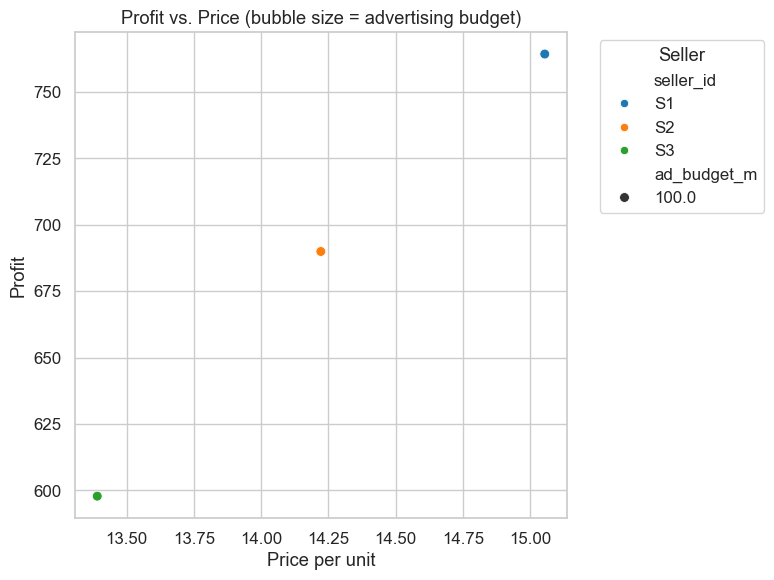

In [36]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=equilibrium,
    x="price_p", y="profit",
    size="ad_budget_m", hue="seller_id",
    palette="tab10", sizes=(50, 300)
)
plt.title("Profit vs. Price (bubble size = advertising budget)")
plt.xlabel("Price per unit")
plt.ylabel("Profit")
plt.legend(title="Seller", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

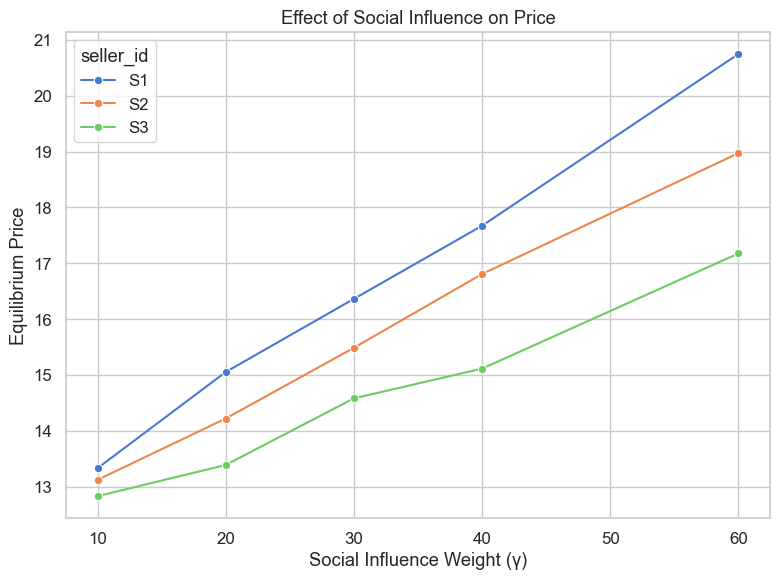

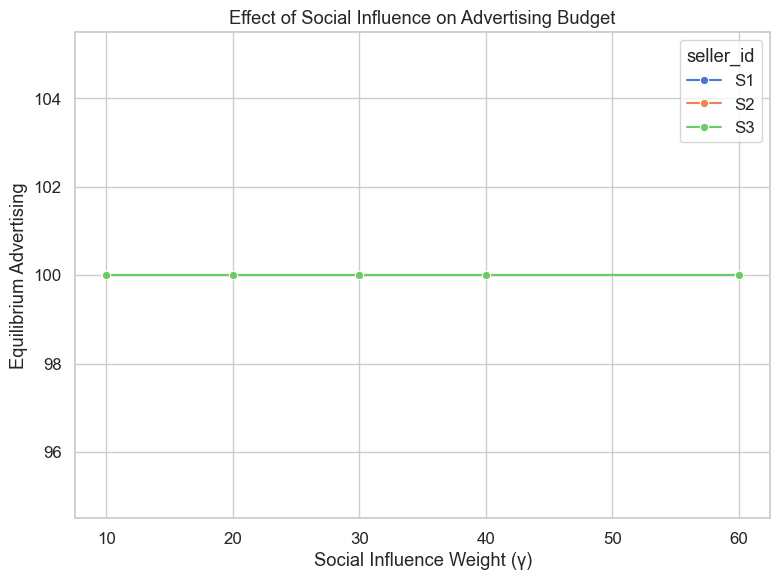

In [38]:
if "all_equilibria" in globals():
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=all_equilibria,
        x="gamma", y="price_p", hue="seller_id", marker="o"
    )
    plt.title("Effect of Social Influence on Price")
    plt.xlabel("Social Influence Weight (γ)")
    plt.ylabel("Equilibrium Price")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=all_equilibria,
        x="gamma", y="ad_budget_m", hue="seller_id", marker="o"
    )
    plt.title("Effect of Social Influence on Advertising Budget")
    plt.xlabel("Social Influence Weight (γ)")
    plt.ylabel("Equilibrium Advertising")
    plt.tight_layout()
    plt.show()

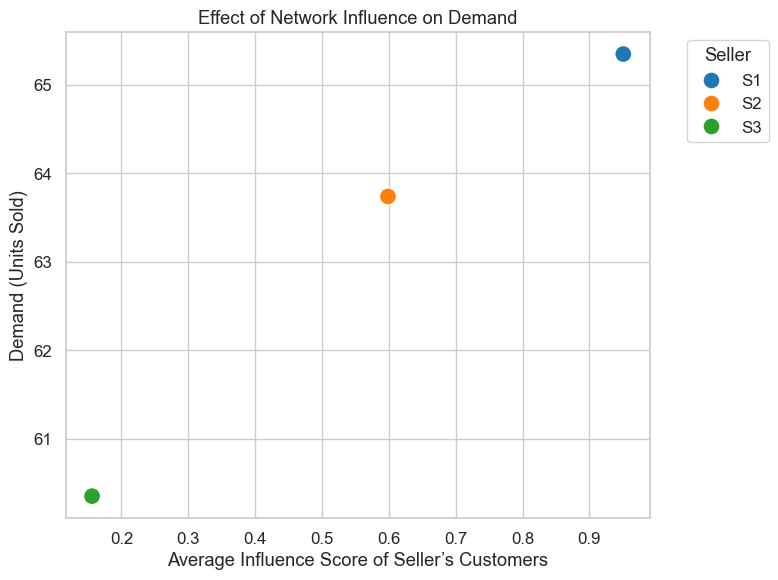

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=equilibrium,
    x="influence_score", y="demand_Di",
    hue="seller_id", s=150, palette="tab10"
)
plt.title("Effect of Network Influence on Demand")
plt.xlabel("Average Influence Score of Seller’s Customers")
plt.ylabel("Demand (Units Sold)")
plt.legend(title="Seller", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

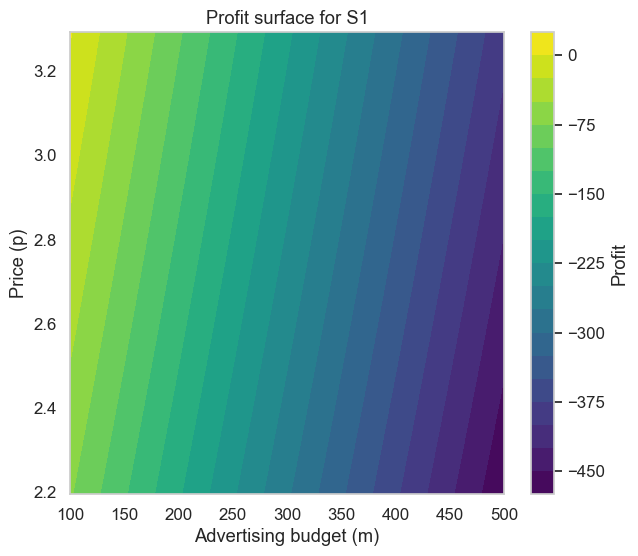

In [40]:
# pick one seller
seller = game_sellers.iloc[0]

p_j = np.mean(game_sellers.loc[game_sellers["seller_id"] != seller["seller_id"], "price_p"])
cost = seller["cost"]
influence = seller["influence_score"]

price_range = np.linspace(seller["price_p"] * 0.8, seller["price_p"] * 1.2, 30)
ad_range = np.linspace(100, 500, 30)

profit_grid = np.zeros((len(price_range), len(ad_range)))

for i, p_i in enumerate(price_range):
    for j, m_i in enumerate(ad_range):
        profit_grid[i, j], _ = profit_given_strategy(p_i, m_i, p_j, influence, cost)

plt.figure(figsize=(7,6))
contour = plt.contourf(ad_range, price_range, profit_grid, 20, cmap="viridis")
plt.colorbar(contour, label="Profit")
plt.xlabel("Advertising budget (m)")
plt.ylabel("Price (p)")
plt.title(f"Profit surface for {seller['seller_id']}")
plt.show()


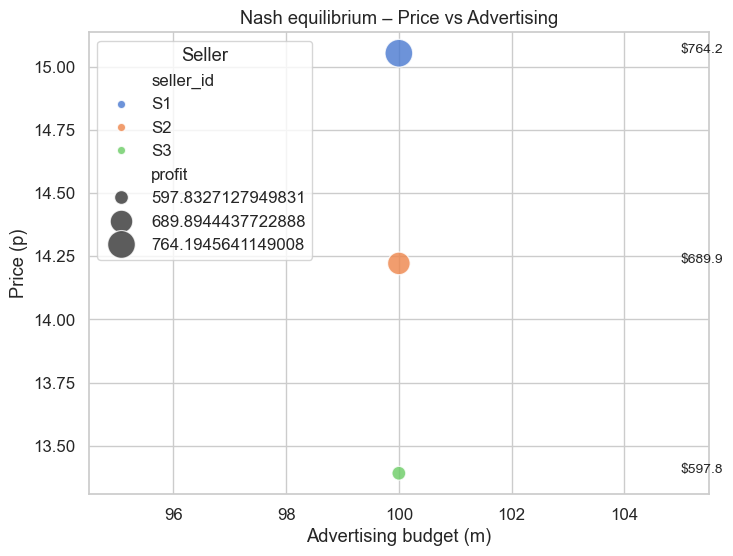

In [41]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=equilibrium,
                x="ad_budget_m", y="price_p",
                size="profit", hue="seller_id",
                sizes=(100,400), alpha=0.8)

for _, row in equilibrium.iterrows():
    plt.text(row["ad_budget_m"]+5, row["price_p"],
             f"${row['profit']:.1f}", fontsize=10)

plt.xlabel("Advertising budget (m)")
plt.ylabel("Price (p)")
plt.title("Nash equilibrium – Price vs Advertising")
plt.legend(title="Seller")
plt.show()


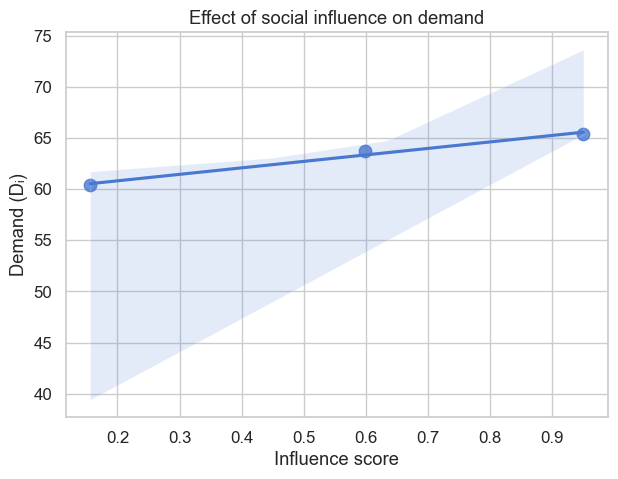

In [42]:
plt.figure(figsize=(7,5))
sns.regplot(data=equilibrium, x="influence_score", y="demand_Di",
            scatter_kws={"s":80, "alpha":0.8})
plt.title("Effect of social influence on demand")
plt.xlabel("Influence score")
plt.ylabel("Demand (Dᵢ)")
plt.show()
